<a href="https://colab.research.google.com/github/machineska/stock_prediction/blob/master/regline_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data from yahoo finance website
- `https://finance.yahoo.com/quote/AAPL/history?p=AAPL`
- data start from 1st January 2000 to 5th Sept 2019

In [0]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame


start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2019, 9, 5)

df = web.DataReader("AAPL", 'yahoo', start, end)

In [0]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

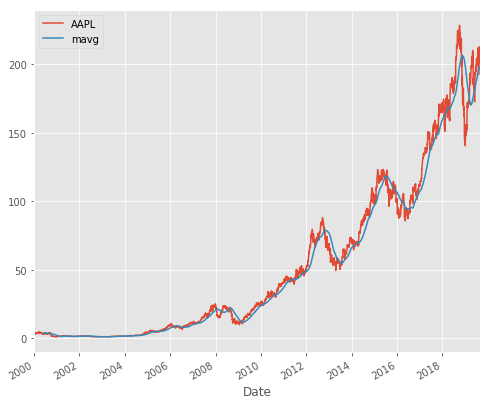

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

In [0]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [0]:
import math
import numpy as np
from sklearn import preprocessing

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution 
# for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) 
# for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [0]:
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing, svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

In [100]:
# Separation of training and testing of model by cross validation train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly_ridge = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly_ridge.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly_lasso = make_pipeline(PolynomialFeatures(3), Lasso())
clfpoly_lasso.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('lasso',
                 Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

# Test Model

In [102]:
confidencereg = clfreg.score(X_test, y_test)
confidence_poly_ridge = clfpoly_ridge.score(X_test,y_test)
confidence_poly_lasso = clfpoly_lasso.score(X_test,y_test)

print("The linear regression confidence is ",confidencereg)
print("The quadratic regression poly 2 confidence with ridge is ",confidence_poly_ridge)
print("The quadratic regression poly 3 confidence with lasso is ",confidence_poly_lasso)

The linear regression confidence is  0.9706310017495008
The quadratic regression poly 2 confidence with ridge is  0.9742154469406834
The quadratic regression poly 3 confidence with lasso is  0.9734604462364902


In [103]:
dfreg.iloc[-1].name

Timestamp('2019-09-05 00:00:00')

In [0]:
def predict_data(dataframe, clf):
  # Printing the forecast for Linear Regression
  last_date = dataframe.iloc[-1].name
  forecast_set = clf.predict(X_lately)
  dataframe['Forecast'] = np.nanlast_date = dataframe.iloc[-1].name
  last_unix = last_date
  next_unix = last_unix + datetime.timedelta(days=1)

  for i in forecast_set:
      next_date = next_unix
      next_unix += datetime.timedelta(days=1)
      dataframe.loc[next_date] = [
          np.nan for _ in range(len(dataframe.columns)-1)
      ]+[i]
  
  return dataframe

In [0]:
def draw_prediction(dataframe):
  dataframe['Adj Close'].tail(500).plot()
  dataframe['Forecast'].tail(50).plot()
  plt.legend(loc=4)
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.show()

### PLOT for linear regression

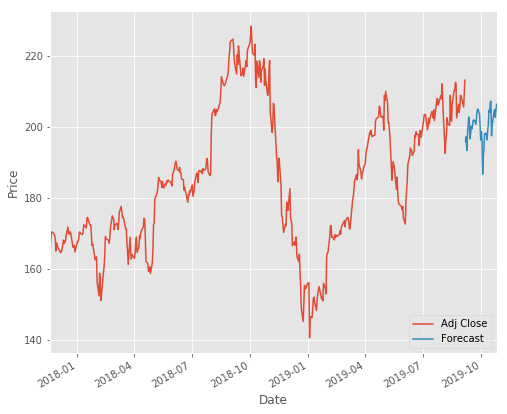

In [114]:
import copy

dataframe_reg_regular = predict_data(copy.deepcopy(dfreg), clfpoly_ridge)
draw_prediction(dataframe_reg_regular)

# PLOT for linear regression with Ridge

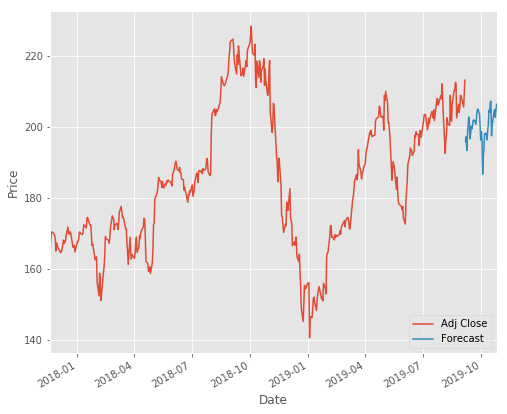

In [115]:
dataframe_reg_poly_ridge = predict_data(copy.deepcopy(dfreg), clfpoly_ridge)
draw_prediction(dataframe_reg_poly_ridge)

# PLOT for linear regression with Laso

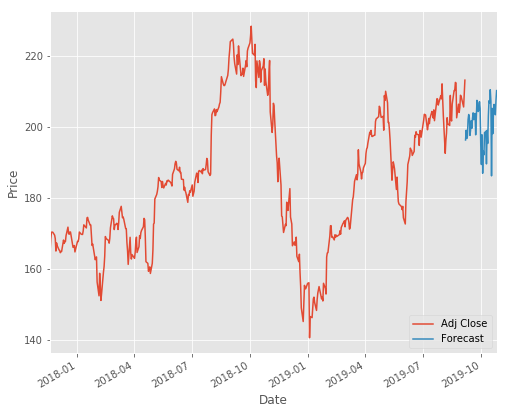

In [116]:
dataframe_reg_poly_laso = predict_data(copy.deepcopy(dfreg), clfpoly_lasso)
draw_prediction(dataframe_reg_poly_laso)